### <p style="text-align: right;"> &#9989; Andrew Koren.</p>

# PHY480 Homework 5

The goal of this homework is to perform a simulation of the two-dimensional Ising model on lattices of different sizes (up to $20\times20$) and at different inverse temperatures $\beta$. From such simulations one can estimate the average energy density, specific heat, average magnetization and magnetic susceptibility. (These quantities allow one to find the critical temperature as well as to determine the critical exponents of the two-dimensional Ising model universality class.)

**There are 7 problems with the total of 58 points.**

**The deadline for the homework is Friday, April 18, 2025, 6:00 pm.**



In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Lattice indexing functions are provided below. They allow one to initialize a lattice object in arbitrary dimension. The lattice sites then can simply adressed by an integer index (i.e. in loops) that ranges from zero up to the total number of sites.

In [31]:
# lattice indexer

# class for lattice indexing with support of arbitary dimensionality
# Input:
# number of dimensions
# lattice size array
class lattice:
    
    def __init__( self, num_dim, size ):
        
        self._is_init = False
        if type(num_dim) != int:
            print( "ERROR: lattice class initializaiton: num_dim must be integer.")
            return
        if len( size ) != num_dim:
            print( "ERROR: lattice class initialization: size array does not match num_dim." )
            return
        for i in range( num_dim ):
            if size[i] < 0:
                print( "ERROR: lattice class initialization: size must be positive." )
                return
        
        # initialization flag
        self._is_init = True
        # number of dimensions
        self._num_dim = int( num_dim )
        # lattice size
        self._size = np.array( size, dtype=int )
        # total number of sites (volume)
        self._volume = 1
        for i in range( num_dim ):
            self._volume *= size[i]
        self._volume = int(self._volume)
            
        # forward and backward nearest neighbor index arrays
        # (periodic boundary conditions)
        self._neighbor_forward  = np.zeros( ( self._volume, self._num_dim ), dtype=int )
        self._neighbor_backward = np.zeros( ( self._volume, self._num_dim ), dtype=int )
        for i in range( self._volume ):
            r = self.map_index_to_vec( i )
            for j in range( self._num_dim ):
                
                # forward
                # index to vector
                q = r.copy()
                q[j] += 1
                q[j] %= self._size[j]
                # vector to index
                self._neighbor_forward[i,j] = self.map_vec_to_index( q )

                # backward
                # index to vector
                q = r.copy()
                q[j] += self._size[j] - 1
                q[j] %= self._size[j]
                # vector to index
                self._neighbor_backward[i,j] = self.map_vec_to_index( q )


    # convert site coordinates to linear index
    # Input:
    # r -- coordinate array
    # Output:
    # linear integer site index
    def map_vec_to_index( self, r ):
        
        if self._is_init == False:
            print( "ERROR: attempt to call map_vec_to_index on an unitialized lattice instance.")
            return -1
        if len(r) != self._num_dim:
            print( "ERROR: in map_vec_to_index vector has wrong dimensions:", len(r) )
            return -2
        for i in range(self._num_dim):
            if r[i]<0 or r[i]>=self._size[i]:
                print( "ERROR: in map_vec_to_index vector component", i, "is out of range." )
                return -3
            
        index = 0
        v = 1
        for i in range(self._num_dim):
            index += int(r[i])*v
            v *= self._size[i]
            
        return int(index)
    
    # convert linear site index to site coordinates
    # Input:
    # index -- linear integer site index
    # Output:
    # site coordinate array
    def map_index_to_vec( self, index ):

        if self._is_init == False:
            print( "ERROR: attempt to call map_index_to_vec on an unitialized lattice instance.")
            return -1
        if index < 0 or index >= self._volume:
            print( "ERROR: in map_index_to_vec index is out of range.")
            return -2
            
        v = int(index)
        r = np.zeros( self._num_dim, dtype=int )
        for i in range(self._num_dim):
            r[i] = int( v % self._size[i] )
            v = v // self._size[i]
        
        return r


**Problem 1 (5 points).** Write two functions which inialize an array of spins in the following way: a) spins are chosen uniformly randomly $+1$ or $-1$ (so-called hot start), b) spins are all set to +1 (cold start).

In [32]:
# initialize spin array randomly
# Input:
# spin -- array of size volume
# volume -- total number of sites on the lattice
# Output:
# no value returned, but the spin array is changed
def make_hot_start( spin_lat, J = 1 ):

    volume = spin_lat._volume
    states = (np.random.rand(volume) < 0.5)*2-1
    spin_lat._states = states
    spin_lat._J = J
    
        
# initialize spin array to 1 for all spins
# Input:
# spin -- array of size volume
# volume -- total number of sites on the lattice
# Output:
# no value returned, but the spin array is changed
def make_cold_start( spin_lat, J = 1 ):


    volume = spin_lat._volume
    states = np.ones(volume, dtype=int)
    spin_lat._states = states
    spin_lat._J = J



**Problem 2 (5 points).** Write a function that computes contribution to the energy for a given value `iq` ($+1$ or $-1$, provided as input) of the spin on site `isite`. Test it on a given hot and cold configuration to make sure it works properly. Test it in one and two dimensions. The `lat` object should be initialized and the `spin` array allocated, i.e. `spin=np.array( lat._volume, dtype=int )`.


In [33]:
# compute local contribution to the energy if the spin on site isite has value iq
# Input:
# lat -- lattice object
# spin -- spin array
# isite -- integer index of the site for which the energy contribution is computed
# iq -- spin value (+1 or -1)
# Output:
# energy, computed as sum of the -J sigma_i sigma_j for the site isite and its nearest neighbors
def compute_energy( spin_lat, isite, iq=None):
    
    J = spin_lat._J

    if iq == None:
        sigma_i = spin_lat._states[isite]
    else:
        sigma_i = iq

    neigbor_indicies = [spin_lat._neighbor_forward[isite,dim] for dim in range(spin_lat._num_dim)] + [spin_lat._neighbor_backward[isite,dim] for dim in range(spin_lat._num_dim)]

    sigma_j = spin_lat._states[neigbor_indicies]
    
    energy = -J*sum(sigma_i*sigma_j)

    return energy


**Problem 3 (10 points).** Write a function that implements the Metropolis algorithm to produce a new value at site `isite`:

- generate a new value `q_new`, +1 or -1 with equal probability (50%),
- compute the energy for the current value of `spin[isite]` and for the proposed value `q_new`,
- compute accept/reject probability,
- accept or reject the move based on a uniform random number,
- if the move is accepted, return `q_new` and `acpt=1`, otherwise return `spin[isite]` (old value) and `acpt=0`.

Test this function by choosing a site on a given spin configuration (hot or cold start) and generating a new value for it.

Then write a second function that perform one _sweep_ over the lattice (i.e. loops over all sites and updates each one with the Metropolis algorithm).

In [34]:
# generate a new spin value (+1 or -1) with the Metropolis algorithm based on the
# current nearest neighbor environment
# Input:
# lat -- lattice object
# spin -- array with spin values
# isite -- current site for which new spin value is generated
# J -- Ising model coupling
# beta -- inverse temperature
# Output:
# new spin value generated (can be the same as old, if the proposal is rejected)
# acceptance -- =1 if accepted, =0 if rejected
def generate_spin_met( spin_lat, isite, beta ):

    # propose new spin value (uniform)
    q_new = (np.random.rand() < 0.5)*2-1
    
    # save some compute 
    if spin_lat._states[isite] == q_new:
        return q_new, (np.random.rand() < 0.5)*1

    # compute old energy
    Eold = compute_energy(spin_lat, isite)
    
    # compute new energy
    Enew = compute_energy(spin_lat, isite, q_new)

    # accept/reject
    Pnew = 1/(1+np.exp(beta*(Enew-Eold)))
    if Pnew > np.random.rand():
        spin_lat._states[isite] = q_new
        return q_new, 1        
    else:
        return spin_lat._states[isite], 0

In [35]:
# make one sweep through the lattice, updating each spin with the Metropolis algorithm
# Input:
# lat -- lattice object
# spin -- array with spin values
# J -- Ising model coupling
# beta -- inverse temperature
# Output:
# total sum of accepted moves
def sweep_met( spin_lat, beta ):
    
    new_spin = []
    acceptance_total = 0
    
    for isite in range(spin_lat._volume):
        spin, acceptance = generate_spin_met( spin_lat, isite, beta) # updates during sweep?
        new_spin.append(spin)
        acceptance_total += acceptance

    return acceptance_total


In [36]:
spin_lat = lattice( 2, (2,2))
make_cold_start(spin_lat, J=1)
spin_lat._volume

4

**Problem 4 (5 points).** Write a function that computes the average magnetization, i.e. for a given lattice configuration it sums the value of all spins and divides by the number of sites.


In [37]:
# Input:
# lat -- lattice object
# spin -- array with spin values
# Output:
# average magnetization
def compute_mag( spin_lat ):
    
    return spin_lat._states.sum()/spin_lat._volume


**Problem 5 (10 points).** Implement a function which performs a Monte Carlo simulation. Namely, it performs `Nequi` sweeps for equilibration when no measurements are taken. Then it performs sweeps in a double loop: `Nsim` and `Ninner` where the measurements are taken in the `Nsim` loop only. (This allows us to control the number of measurements, so it does not get too large, for instance, if `Nsim=10` and `Ninner=3`, in total the simulation will perform 30 sweeps through the lattice, however, only every third sweep a measurement is taken, resulting in 10 measurements.) What we are going to measure is the energy density and average magnetization. Energy density calculation can be achieved with the `compute_energy` function written earlier: that function computes the contribution into the total energy for a given site. If we call it for every site, we get twice the total energy (because in such a sum the pairs are double counted). We normalize the energy by dividing that total by 2 and by the total number of _links_ on the lattice (which is equal to the number of sites times the number of dimensions), i.e. we compute the energy density. For the average magnetization use the function you wrote earlier. The `simulate_met` function should measure the energy density and magnetization at every iteration of the `Nsim` loop and return an array with the energy density values, array with the magnetization values and the acceptance rate.

In [56]:
# make a simulation with Nequi sweeps for equilibration and Nsim x Ninner sweeps,
# measurements are performed once in every Ninner sweeps
# Input:
# lat -- lattice object
# spin -- spin array
# J -- Ising model coupling
# beta -- inverse temperature
# Nequi -- number of sweeps for equilibration
# Nsim -- number of simulation steps in the outer loop, where the measurements are performed
# Ninner -- number of simulations steps (i.e. sweeps) in the inner loop without measurements
# Output:
# array with energy density values of size Nsim
# acceptance rate
def simulate_met( spin_lat, beta, Nequi, Nsim, Ninner ):

    # equilibration
    for i in range(Nequi):
        sweep_met(spin_lat, beta)

        
    # initialize energy array
    Energies = []
    Mags = []
    acceptance_rates = []
    # main production loop: Nsim
    for _ in range(Nsim):
        total_acceptance = 0
        # inner loop: Ninner
        for _ in range(Ninner):
            # sweep over the lattice
            total_acceptance += sweep_met(spin_lat, beta)

        # compute the energy density
        energy = sum([compute_energy(spin_lat, i) for i in range(spin_lat._volume)])
        Energies.append(energy/2)
        acceptance_rate = total_acceptance/(Ninner*spin_lat._volume)

        Mags.append(compute_mag(spin_lat))
        acceptance_rates.append(acceptance_rate)
        
        
    return Energies, Mags,  acceptance_rates

**Problem 6 (15 points).** Perform a simulation for the two-dimensional Ising model on a $N\times N$ lattice. Scan a range of inverse temperature `beta` given below. In other words, make a double loop: on lattice sizes and (internally) on beta values. For each beta value, based on the values that `simulate_met` returns, compute ($V=N\times N$ is the volume, i.e. total number of sites and $d$(=2) is the dimension):

- average energy density (energy counted per _link_):

$$
\frac{\langle E \rangle}{Vd},
$$

- specific heat:

$$
C = \frac{\beta^2}{V}(\langle E^2\rangle - \langle E\rangle^2),
$$

- average absolute value of the magnetization (here $M$ is the sum of all spins in the configuration):

$$
\frac{\langle |M|\rangle}{V},
$$

- magnetic susceptibility:

$$
\chi = \frac{1}{V}(\langle M^2\rangle - \langle |M|\rangle^2).
$$

For simulation parameters use `Nequi = 400`, `Nsim = 2000` and `Ninner = 8`. The $\beta$ values are chosen around the infinite-volume critical temperature $\beta_c\approx 0.44$.



In [39]:
# fix random seed for reproducibility
np.random.seed(3)
hot = True
start = [make_cold_start, make_hot_start]

In [ ]:
import pandas as pd
#experiment_results = pd.DataFrame(columns=['Lattice Size', 'beta', 'mean energy per link', 'specific heat', 'mean magnetization', 'susceptibility', 'acceptance rate' ])


In [ ]:

# lattice sizes for simulation
# (work with small lattices, e.g., 6, 8, before your code works properly,
# then do a production run, it will take some time for the largest lattice)
lat_size = [10,12,16,20]

# inverse temperature beta's for simulation
betas = [ 0.2, 0.3, 0.35, 0.38, 0.4, 0.42, 0.43, 0.44, 0.45, 0.47, 0.5, 0.6, 0.7 ]

# array for storing time series


# loop over lattice sizes
for l in range( len(lat_size) ):
    
    print( "Lattice size:", lat_size[l] )
    print() # empty on purpose

    # loop over beta values
    for i in range( len(betas) ):

        # parameters
        J = 1 # coupling
        beta = betas[i] # inverse temperature

        # initialize spins
        spin_lat = lattice(2, (lat_size[l], lat_size[l]))
        V = spin_lat._volume

        # make a hot or cold start
        start[hot](spin_lat, J)

        # simulation parameters
        Nequi = 400
        Nsim = 2000
        Ninner = 8

        # call the simulation function simulate_met
        energies, mags, rates = simulate_met(spin_lat, beta, Nequi, Nsim, Ninner)
    
        # compute the observables
        print( "beta: ", beta )

        # print average energy density, specific heat,
        print(f"mean energy per link: {np.mean(energies)/(V*2):.3f}")
        print(f"specific heat: {beta**2*np.std(energies)**2/V:.3f}" )
        
        # average magnetization, magnetic susceptibility,
        print(f"mean magnetization: {np.mean(mags)/V:.5f}")
        print(f"susceptibility: {np.std(mags)**2/V:.5f}")

        # acceptance rate
        print(f"acceptance rate: {np.mean(rates):.3f}")
        print()

        experiment_results.loc[len(experiment_results)] = [
            lat_size[l], 
            beta, 
            np.mean(energies)/(V*2), 
            beta**2*np.std(energies)**2/V,  
            abs(np.mean(mags)/V),
            np.std(mags)**2/V,
            np.mean(rates)
            ]
    print()


Lattice size: 10

beta:  0.2
mean energy per link: -0.216
specific heat: 0.100
mean magnetization: 0.00007
susceptibility: 0.00028
acceptance rate: 0.462

beta:  0.3
mean energy per link: -0.353
specific heat: 0.301
mean magnetization: -0.00005
susceptibility: 0.00074
acceptance rate: 0.419

beta:  0.35
mean energy per link: -0.451
specific heat: 0.537
mean magnetization: -0.00010
susceptibility: 0.00149
acceptance rate: 0.390

beta:  0.38
mean energy per link: -0.521
specific heat: 0.858
mean magnetization: 0.00014
susceptibility: 0.00241
acceptance rate: 0.370

beta:  0.4
mean energy per link: -0.601
specific heat: 1.153
mean magnetization: -0.00124
susceptibility: 0.00360
acceptance rate: 0.350

beta:  0.42
mean energy per link: -0.665
specific heat: 1.238
mean magnetization: -0.00295
susceptibility: 0.00390
acceptance rate: 0.334

beta:  0.43
mean energy per link: -0.703
specific heat: 1.312
mean magnetization: -0.00088
susceptibility: 0.00545
acceptance rate: 0.324

beta:  0.44
me

**Problem 7 (8 points).** Plot each quantity you computed in the previous problem on a single plot as function of $\beta$ for all simulated lattice sizes.

In [98]:
experiment_results

,Lattice Size,beta,mean energy per link,specific heat,mean magnetization,susceptibility,acceptance rate
0,6,0.20,-0.220250,0.104431,0.000211,2.244533e-03,0.461472
1,6,0.30,-0.368250,0.356060,0.000706,5.235871e-03,0.415833
2,6,0.35,-0.490389,0.705767,0.001082,9.035717e-03,0.380483
3,6,0.38,-0.571528,0.935381,0.000375,1.204492e-02,0.359618
4,6,0.40,-0.637806,1.018711,0.001354,1.454797e-02,0.343007
...,...,...,...,...,...,...,...
73,20.0,0.45,-0.760188,1.484180,0.000292,1.491903e-03,0.310331
74,20.0,0.47,-0.817290,1.136117,0.002114,3.009613e-05,0.296823
75,20.0,0.50,-0.870725,0.781990,0.002268,6.625826e-06,0.283461
76,20.0,0.60,-0.954333,0.319157,0.002434,6.233556e-07,0.262155


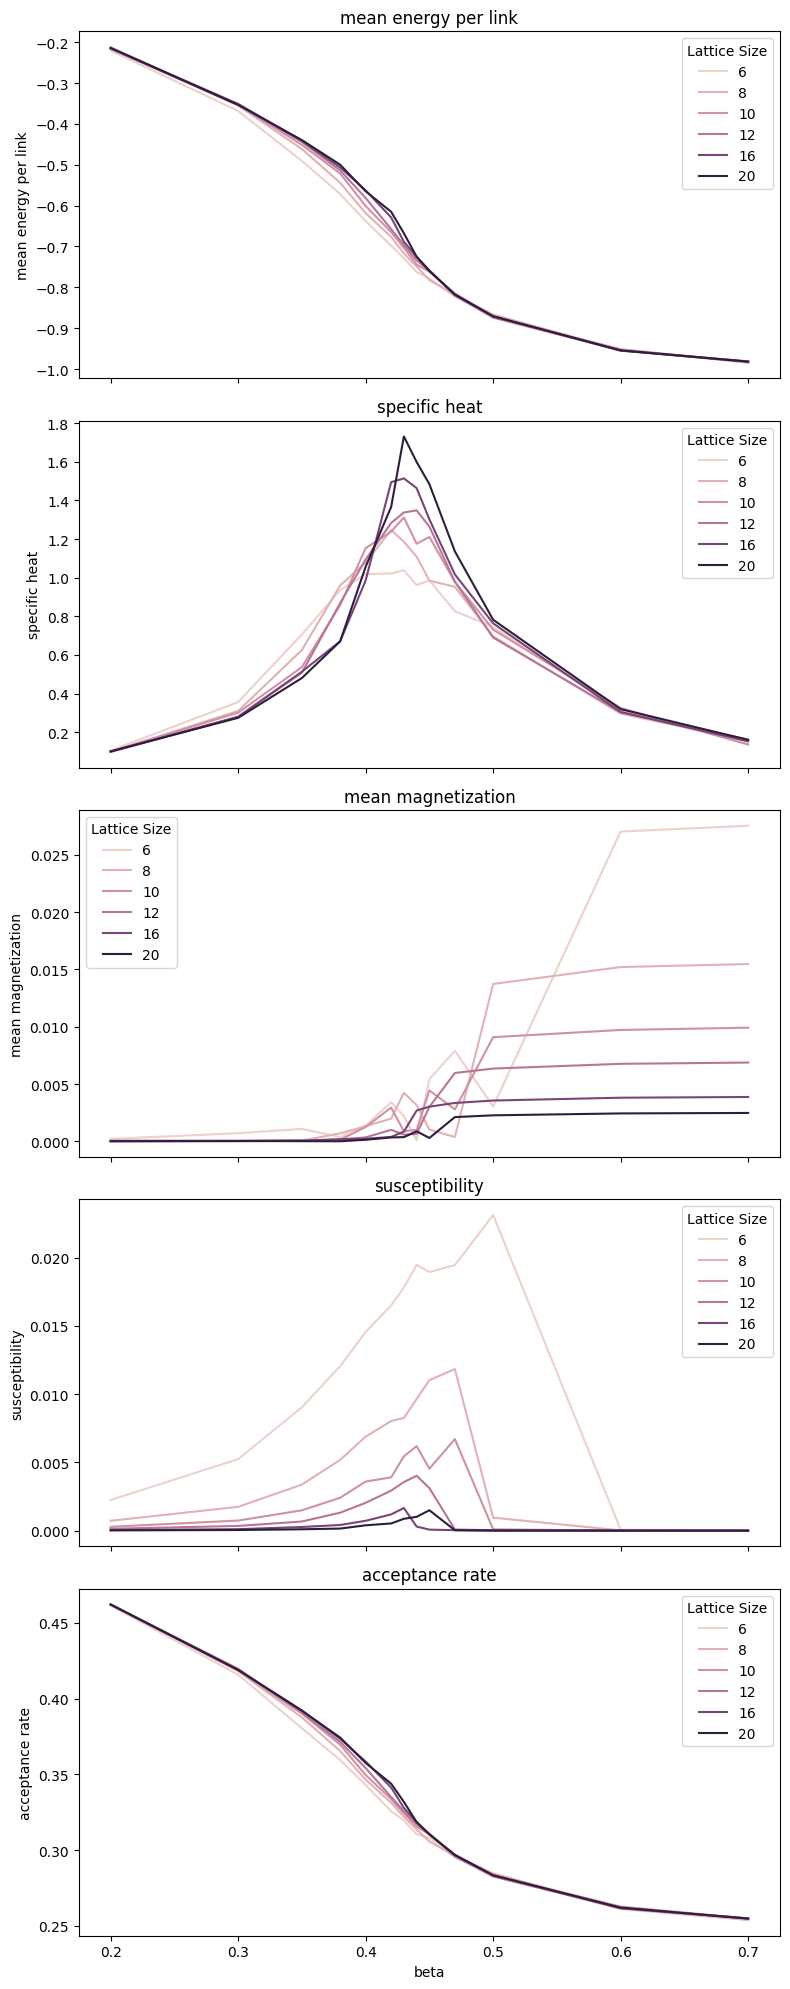

In [99]:
# YOUR CODE HERE
import seaborn as sns

# Ensure you have the correct column names
metrics = experiment_results.keys()[2:]
# Set up the subplot grid
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 4 * len(metrics)), sharex=True)

# Plot each metric
for i, metric in enumerate(metrics):
    sns.lineplot(
        data=experiment_results,
        x='beta',
        y=metric,
        hue='Lattice Size',
        ax=axes[i]
    )
    axes[i].set_title(metric)
    axes[i].legend(title='Lattice Size')

plt.tight_layout()
plt.show()


&#169; Copyright 2025,  Michigan State University Board of Trustees